# Generic microbiome analysis notebook
This is a jupyter notebook example of how to load, process and plot data from a microbiome experiment using Calour.

### Import the calour module

In [1]:
import calour as ca

/Users/amnon/miniconda3/envs/calour/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### (optional) Set the level of feedback messages from calour
can use:

* 1 for debug (lots of feedback on each command)

* 11 for info (useful information from some commands)

* 21 for warning (just warning messages)

The Calour default is warning (21)

In [2]:
ca.set_log_level(11)

### Also enable interactive plots inside the jupyter notebook

In [3]:
%matplotlib notebook

## Loading the data
If using via mybinder, first upload your biom table and mapping file to the mybinder server

See [here](http://biocore.github.io/calour/generated/calour.io.read_amplicon.html#calour.io.read_amplicon) for all possible parameters for read_amplicon()



In [5]:
newdat=ca.read_amplicon(data_file='./YOUR_BIOM_TABLE.biom',
                     sample_metadata_file='./YOUR_MAPPING_FILE.txt',
                     normalize=10000,min_reads=1000)

2018-07-26 13:31:11 INFO loaded 87 samples, 2129 features
2018-07-26 13:31:11 WARNING These have metadata but do not have data - dropped: {'ERR1331814'}
2018-07-26 13:31:11 INFO After filtering, 87 remaining


For demonstration, we use the CFS dataset from:

Giloteaux, L., Goodrich, J.K., Walters, W.A., Levine, S.M., Ley, R.E. and Hanson, M.R., 2016.

Reduced diversity and altered composition of the gut microbiome in individuals with myalgic encephalomyelitis/chronic fatigue syndrome.

Microbiome, 4(1), p.30.


In [16]:
dat=ca.read_amplicon(data_file='./data/cfs.biom',
                     sample_metadata_file='./data/cfs_sample.txt',
                     normalize=10000,min_reads=1000)

2018-07-26 14:31:29 INFO loaded 87 samples, 2129 features
2018-07-26 14:31:30 INFO After filtering, 87 remaining


In [17]:
print(dat)

AmpliconExperiment ("cfs.biom") with 87 samples, 2129 features


## Process the data

### Get rid of the features (bacteria) with small amount of reads
We throw away all features with total reads (over all samples) < 10 (after each sample was normalized to 10k reads/sample). So a bacteria present (with 1 read) in 10 samples will be kept, as well as a bacteria present in only one sample, with 10 reads in this sample.
Note alternatively we could filter based on mean reads/sample or fraction of samples where the feature is present. Each method filters away slightly different bacteria. See **filtering** notebook for details on the filtering functions.

In [18]:
dat=dat.filter_abundance(10)

2018-07-26 14:31:31 INFO After filtering, 1100 remaining


### Cluster (reorder) the features so similarly behaving bacteria are close to each other
Features are clustered (hierarchical clustering) based on euaclidian distance between features (over all samples) following normalizing each feature to mean 0 std 1. For more details and examples, see **sorting** notebook or **cluster_features documentation**

* Note that if we have a lot of features, clustering is slow, so it is recommended to first filter away the non-interesting features.


In [19]:
datc=dat.cluster_features()

2018-07-26 14:31:32 INFO After filtering, 1100 remaining


### Sort the samples according to physical functioning and Disease state
Note that order within each group of similar value is maintained. We first sort by physical functioning, then sort by the disease state. So within each disease state, samples will still be sorted by physical functioning.

In [21]:
datc=datc.sort_samples('Physical_functioning')
datc=datc.sort_samples('Subject')

## Plotting the data
Columns (x-axis) are the samples, rows (y-axis) are the features. We will show on the x-axis the host-individual field of each sample.

we will use the jupyter notebook GUI so we will see the interactive plot in the notebook. Alternatively we could use the qt5 GUI to see the plot in a separate standalone window.

A few cool things we can do with the interactive plot:

* Click with the mouse on the heatmap to see details about the feature/sample selected (including information from **dbBact**).

* use SHIFT+UP or SHIFT+DOWN to zoom in/out on the features

* use UP/DOWN to scroll up/down on the features

* use SHIFT+RIGHT or SHIFT+LEFT to zoom in/out on the samples

* use RIGHT/LEFT to scroll left/right on the samples

See **here** for more details

<IPython.core.display.Javascript object>


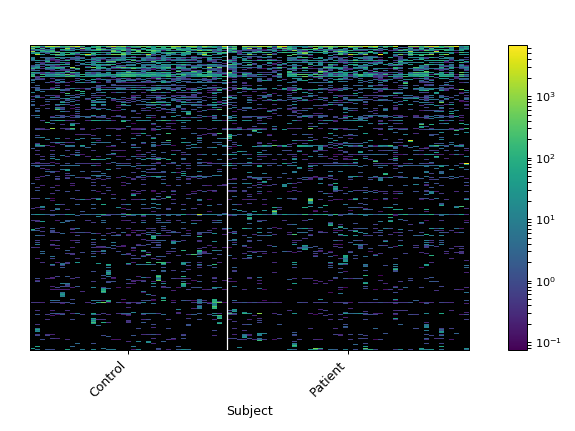

In [11]:
datc.plot(sample_field='Subject', gui='jupyter')

### Adding a field to the top bar
Now let's add the values of the "Sex" field into the xbar on top
First we'll also sort by sex, so values will be continuous (note we then sort by the disease state to get the two groups separated).

In [12]:
datc=datc.sort_samples('Sex')
datc=datc.sort_samples('Subject')

<IPython.core.display.Javascript object>


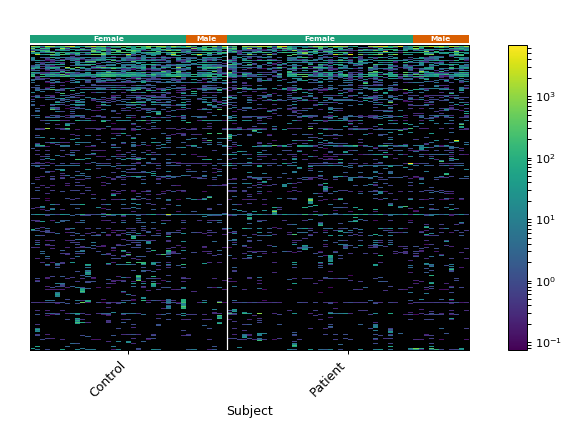

In [13]:
datc.plot(sample_field='Subject', gui='jupyter',barx_fields=['Sex'])

### Differential abundance testing
Let's look for bacteria separating sick from healthy
We ask it to find all bacteria significantly different between samples with 'Control' and 'Patient' in the 'Subject' field.

By default calour uses the mean of the ranks of each feature (over all samples), with dsFDR multiple hypothesis correction.

For more information, see **notebook** and **function doc**

In [14]:
dd=datc.diff_abundance(field='Subject',val1='Control',val2='Patient', random_seed=2018)

2018-07-26 14:30:33 INFO 87 samples with both values
2018-07-26 14:30:33 INFO After filtering, 1100 remaining
2018-07-26 14:30:33 INFO 39 samples with value 1 (['Control'])
2018-07-26 14:30:34 INFO method meandiff. number of higher in ['Control'] : 44. number of higher in ['Patient'] : 19. total 63


### Plotting the differentially abundant features
Let's plot to see the behavior of these bacteria.
The output of diff_abundance is an Experiment with only the significant bacteria, which are sorted by the effect size. On the bottom is the bacteria with the largest effect size (higher in Control compared to Patient).

<IPython.core.display.Javascript object>


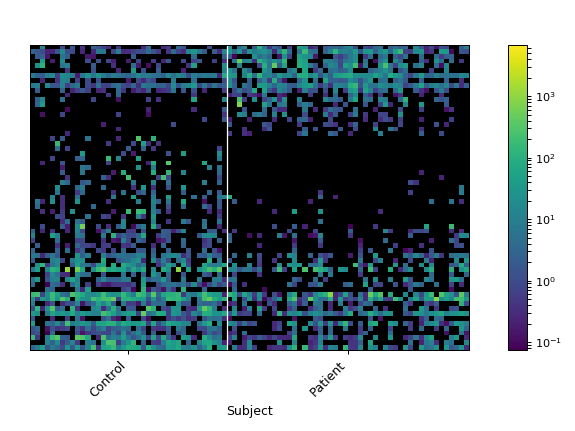

In [15]:
dd.plot(sample_field='Subject', gui='jupyter')

### dbBact term enrichment
We can ask what is special in the bacteria significanly higher in the Control vs. the Patient group and vice versa.

We supply the parameter `ignore_exp=[12]` to ignore annotations regarding this experiment (expid=12) since it is already in the dbBact database.

* Note since we need to get the per-feature annotations from dbBact, we need a live internet connection to run this command.

2018-03-04 12:40:41 INFO Getting dbBact annotations for 63 sequences, please wait...
2018-03-04 12:40:45 INFO Got 2383 annotations
2018-03-04 12:40:45 INFO Added annotation data to experiment. Total 631 annotations, 63 terms
2018-03-04 12:40:45 INFO removed 171 terms


<IPython.core.display.Javascript object>


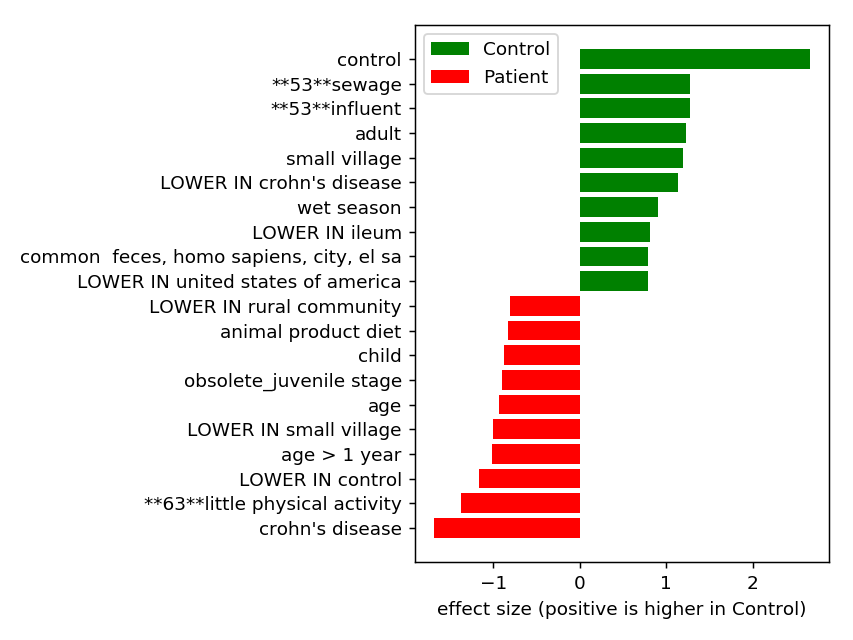

In [14]:
ax, enriched=dd.plot_diff_abundance_enrichment(term_type='combined',ignore_exp=[12])

The enriched terms are in a calour experiment class (terms are features, bacteria are samples), so we can see the
list of enriched terms with the p-value (pval) and effect size (odif)

In [15]:
enriched.feature_metadata

,odif,pvals,term
crohn's disease,-1.688995,0.000999,crohn's disease
**63**little physical activity,-1.368421,0.000999,**63**little physical activity
-control,-1.038876,0.000999,-control
age > 1 year,-1.014354,0.010989,age > 1 year
-small village,-0.997608,0.000999,-small village
age,-0.931873,0.060939,age
obsolete_juvenile stage,-0.898923,0.000999,obsolete_juvenile stage
child,-0.878190,0.006993,child
animal product diet,-0.825359,0.005994,animal product diet
-rural community,-0.803828,0.000999,-rural community
